# Jeff Pinegar
jeffPinegar1@gmail.com <br>
717-982-0516<br>
## Challenge 21 - Deep learning - Nonprofit Foundation Alphabet Soup <br>

Due: March 6, 2023<br>

---

<u>**Summary:**</u><br>
The data prep for this file is very close to the class starter code.  The exception is the ASK_AMT.  The started code offered not insight into what to do with this value.  After multiple attempts to wrangle this column I elected to log scale the values in this column.

<u>**AMT_ASK:**</u><br>
* Logarithmic scaling

<u>**Variables dropped from the model:**</u><br>
* EIN
* Name
* STATUS
* SPECIAL_CONSIDERATIONS

<u>**Binning:**</u><br>
* APPLICATION_TYPE
* CLASSIFICATION

<u>**Special Freatures:**</u><br>
* The results are logged to a CSV file.  The number of neurons for each layer (up to 6) the and the activation function for each layer as well as the final accuracy and loss are recorded.
* Box plot to show the results of the transformed AMT_ASK
* Heatmap showing correlation of independent variables
* Export of ETL data so that it could be used in future model testing.

---

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import csv
import pingouin as pg   # https://pingouin-stats.org/build/html/index.html

---
## Preprocess the Data (Step 1)

Using your knowledge of Pandas and scikit-learn’s `StandardScaler()`, you’ll need to preprocess the dataset. This step prepares you for Step 2, where you'll compile, train, and evaluate the neural network model.

Using the information we have provided in the starter code, follow the instructions to complete the preprocessing steps.

1. Read in the charity_data.csv to a Pandas DataFrame, and be sure to identify the following in your dataset:
    * What variable(s) are the target(s) for your model?
    * What variable(s) are the feature(s) for your model? <br><br>
    

2. Drop the `EIN` and `NAME` columns.

3. Determine the number of unique values for each column.

4. For columns that have more than 10 unique values, determine the number of data points for each unique value.

5. Use the number of data points for each unique value to pick a cutoff point to bin "rare" categorical variables together in a new value, `Other`, and then check if the binning was successful.

6. Use `pd.get_dummies()` to encode categorical variables.

In [2]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("./Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Drop duplicates if they exist (Do this before dropping Nane and EIN)
application_df.drop_duplicates(inplace=True)

# Drop records with na
application_df.dropna(how='any', inplace=True)

In [4]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
#  YOUR CODE GOES HERE
X = application_df.drop(['EIN', 'NAME', 'STATUS', 'SPECIAL_CONSIDERATIONS'], axis=1)

In [5]:
# Determine the number of unique values in each column.
#  YOUR CODE GOES HERE
X.describe(include = 'all').round(3)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
count,34299,34299,34299,34299,34299,34299,3.429900e+04,34299.000
unique,17,6,71,5,4,9,NaN,NaN
top,T3,Independent,C1000,Preservation,Trust,0,NaN,NaN
freq,27037,18480,17326,28095,23515,24388,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.769199e+06,0.532
std,NaN,NaN,NaN,NaN,NaN,NaN,8.713045e+07,0.499
min,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+03,0.000
25%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+03,0.000
50%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+03,1.000
75%,NaN,NaN,NaN,NaN,NaN,NaN,7.742000e+03,1.000


### Reduce APPLICATION_TYPE

In [6]:
# Look at APPLICATION_TYPE value counts for binning
#  YOUR CODE GOES HERE
X['APPLICATION_TYPE'].value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [7]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
#  YOUR CODE GOES HERE
Cutoff = 500
a = X['APPLICATION_TYPE'].value_counts()
application_types_to_replace = a[a < Cutoff].index.tolist()

# Replace in dataframe
for app in application_types_to_replace:
    X['APPLICATION_TYPE'] = X['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
X['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

### Reduce CLASSIFICATION

In [8]:
# Look at CLASSIFICATION value counts for binning
#  YOUR CODE GOES HERE
X['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [9]:
# You may find it helpful to look at CLASSIFICATION value counts >1
#  YOUR CODE GOES HERE
b = X['CLASSIFICATION'].value_counts()
b[b>1]

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
Name: CLASSIFICATION, dtype: int64

<AxesSubplot: >

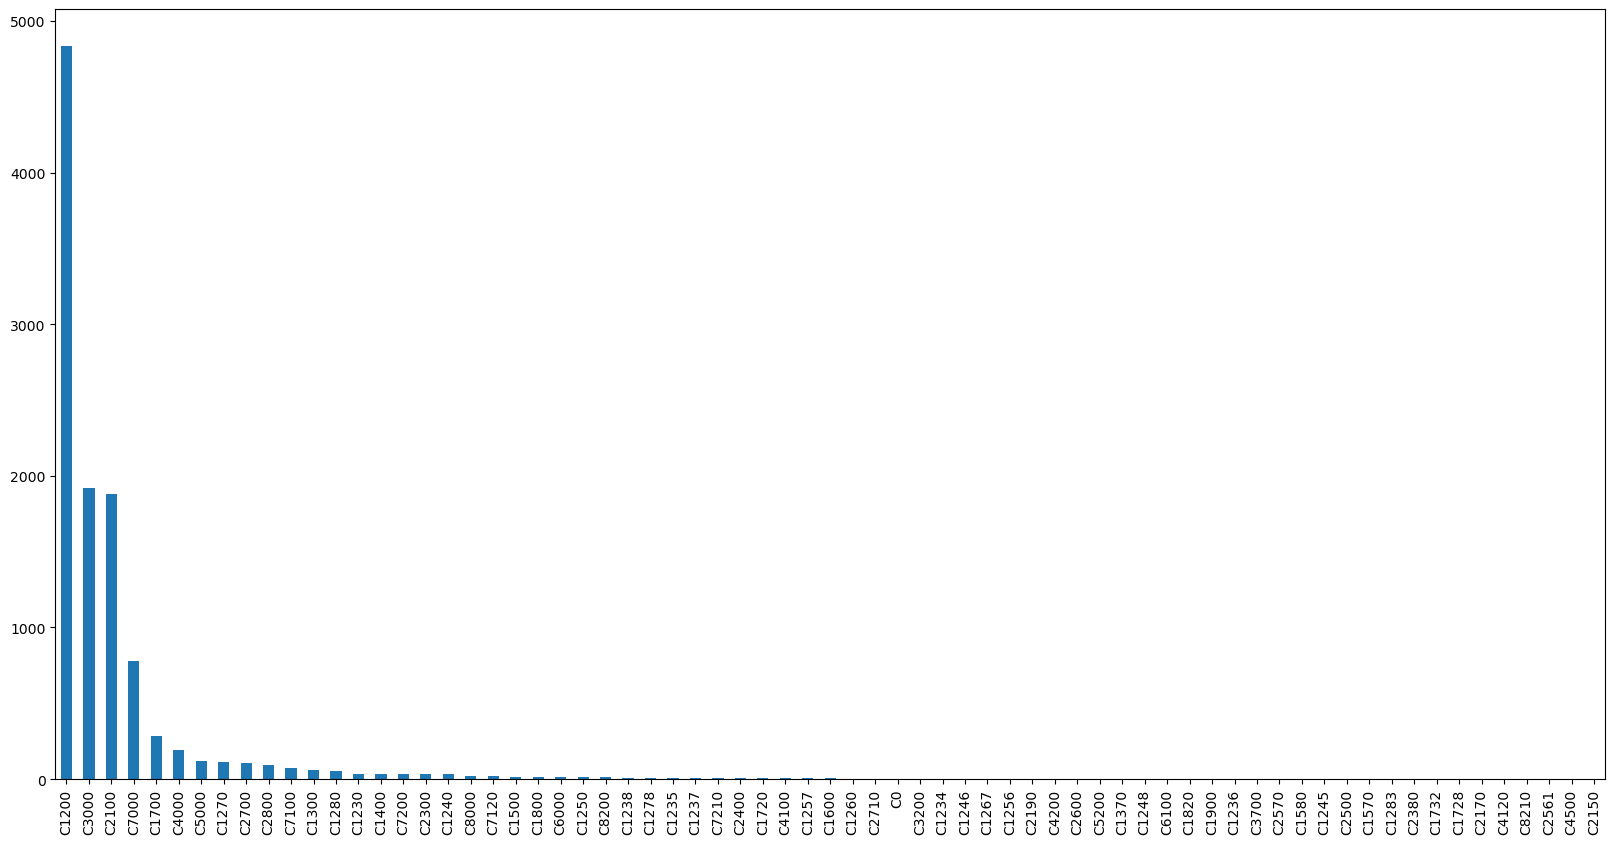

In [10]:
# plot the Classifications to have a closser look at the distribution
b = X['CLASSIFICATION'].value_counts()

# leave off the top two values so the graph is more useful for the intended purpose (further lowering the cutoff)
c = b[b<6000]
c.plot(kind="bar", figsize=(20,10))

In [11]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
#  YOUR CODE GOES HERE
classCutoff = 1000
b = X['CLASSIFICATION'].value_counts()
classifications_to_replace = b[b < classCutoff].index.tolist()

# Replace in dataframe
for cls in classifications_to_replace:
    X['CLASSIFICATION'] = X['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
X['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [12]:
# Look at INCOME_AMT value counts for potential binning
b = X['INCOME_AMT'].value_counts()
b

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

## Scale the ASK_AMT

In [13]:
# because for the very large range of this variable (5,000  to + 10 Billion) I am using a logrithmic transformation.
X['ASK_AMT'] = np.log(X['ASK_AMT'])

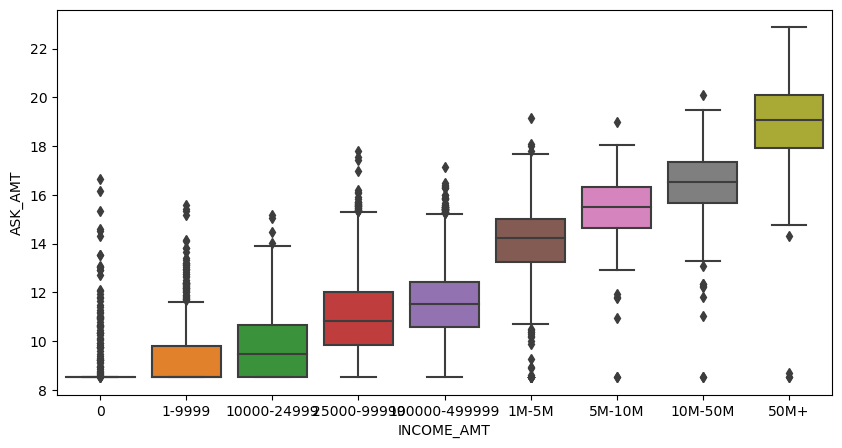

In [14]:
plt.rcParams["figure.figsize"] = [10, 5]
sns.boxplot( x=X['INCOME_AMT']
      , y=X['ASK_AMT']
      , order = ('0', '1-9999', '10000-24999', '25000-99999', '100000-499999', '1M-5M', '5M-10M', '10M-50M', '50M+'))
# plt.ylim(0, 20000000)
plt.show()

In [15]:
# Convert categorical data to numeric with `pd.get_dummies`
#  YOUR CODE GOES HERE
X_dummies = pd.get_dummies(X)
print(X_dummies.columns)
X_dummies

Index(['ASK_AMT', 'IS_SUCCESSFUL', 'APPLICATION_TYPE_Other',
       'APPLICATION_TYPE_T10', 'APPLICATION_TYPE_T19', 'APPLICATION_TYPE_T3',
       'APPLICATION_TYPE_T4', 'APPLICATION_TYPE_T5', 'APPLICATION_TYPE_T6',
       'APPLICATION_TYPE_T7', 'APPLICATION_TYPE_T8',
       'AFFILIATION_CompanySponsored', 'AFFILIATION_Family/Parent',
       'AFFILIATION_Independent', 'AFFILIATION_National', 'AFFILIATION_Other',
       'AFFILIATION_Regional', 'CLASSIFICATION_C1000', 'CLASSIFICATION_C1200',
       'CLASSIFICATION_C2000', 'CLASSIFICATION_C2100', 'CLASSIFICATION_C3000',
       'CLASSIFICATION_Other', 'USE_CASE_CommunityServ', 'USE_CASE_Heathcare',
       'USE_CASE_Other', 'USE_CASE_Preservation', 'USE_CASE_ProductDev',
       'ORGANIZATION_Association', 'ORGANIZATION_Co-operative',
       'ORGANIZATION_Corporation', 'ORGANIZATION_Trust', 'INCOME_AMT_0',
       'INCOME_AMT_1-9999', 'INCOME_AMT_10000-24999',
       'INCOME_AMT_100000-499999', 'INCOME_AMT_10M-50M', 'INCOME_AMT_1M-5M',
       

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,8.517193,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,11.595335,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,8.517193,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,8.808668,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,11.867729,1,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,8.517193,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
34295,8.517193,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
34296,8.517193,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
34297,8.517193,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [16]:
X_dummies.describe(include = 'all').round(3)

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
count,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,...,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000
mean,9.412,0.532,0.008,0.015,0.031,0.788,0.045,0.034,0.035,0.021,...,0.686,0.711,0.021,0.016,0.098,0.007,0.028,0.109,0.004,0.005
std,1.865,0.499,0.089,0.123,0.173,0.409,0.207,0.182,0.185,0.144,...,0.464,0.453,0.144,0.125,0.298,0.083,0.165,0.312,0.064,0.073
min,8.517,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,8.517,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,8.517,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,8.954,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,22.875,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


<AxesSubplot: >

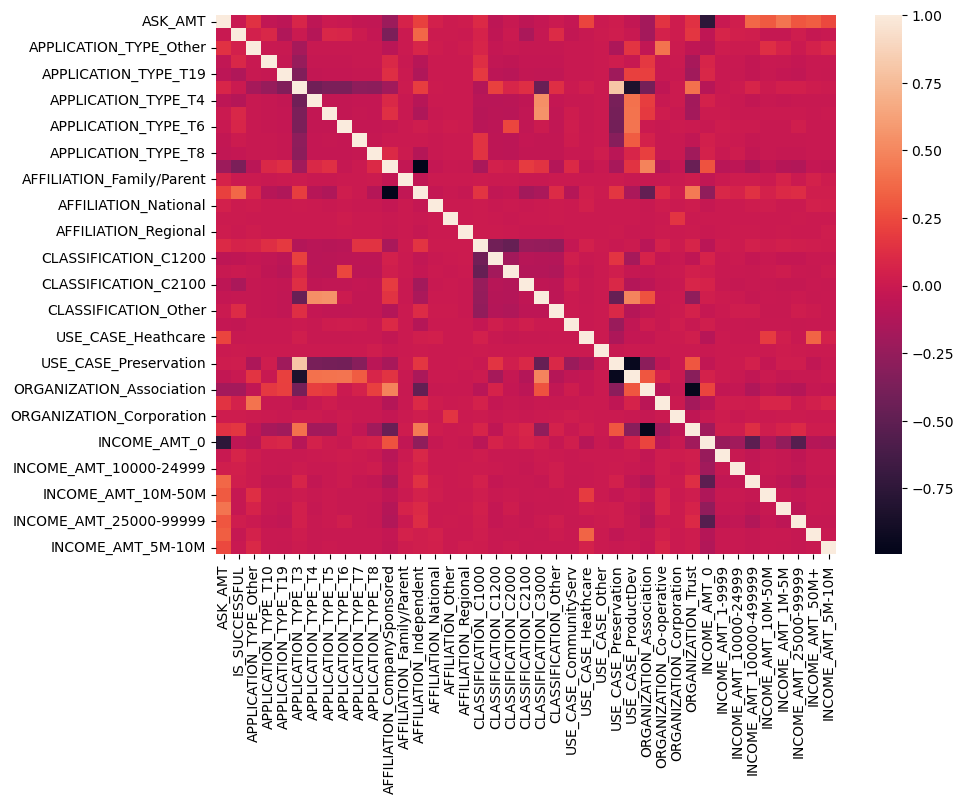

In [17]:
# looking to see if there are any variable that are highly correlated that may be preventing a more accurate model 
plt.figure(figsize=(10,7))
c= X_dummies.corr()
sns.heatmap(c)

# The correlation heat map below indicates the variables are not well separated.  

<u>**Save CVS**</u><br>
Save the dummy encoded data to CSV so that it can imported into other Python programs for Model fitting and testing

In [18]:
# Save the dummy encoded data to CSV so that it can imported into other Python programs for Model fitting and testing
X_dummies.to_csv('clean_data_all_log_dummies.csv', index=False, header=True)

Continue processing this file

In [19]:
# Seperate out the dependent and independen variables
# Split our preprocessed data into our features and target arrays

# this is the target
y = X_dummies["IS_SUCCESSFUL"].values

# Drop y out of the dataframe to get the independent variables
# this is the feature list
X = X_dummies.drop("IS_SUCCESSFUL", axis=1)
independent_variables = X.columns
X.head()


,ASK_AMT,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,8.517193,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,11.595335,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,8.517193,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,8.808668,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,11.867729,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [20]:
X.describe(include = 'all').round(3)

,ASK_AMT,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
count,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,...,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000,34299.000
mean,9.412,0.008,0.015,0.031,0.788,0.045,0.034,0.035,0.021,0.021,...,0.686,0.711,0.021,0.016,0.098,0.007,0.028,0.109,0.004,0.005
std,1.865,0.089,0.123,0.173,0.409,0.207,0.182,0.185,0.144,0.145,...,0.464,0.453,0.144,0.125,0.298,0.083,0.165,0.312,0.064,0.073
min,8.517,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,8.517,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,8.517,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,8.954,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,22.875,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [21]:
# Split the preprocessed data into a training and testing dataset
# Split the data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
# there was only one value that needed Scaling ASK_AMT
# Therefore I scaled that variable earlier in the code so the whole data set could be exported for testing in other code.

# I Copied the dataframes to the the "standard names" so that "cut and Paste code would work"
X_train_scaled = X_train
X_test_scaled = X_test

---
## Compile, Train and Evaluate the Model (Step 2)
Using your knowledge of TensorFlow, you’ll design a neural network, or deep learning model, to create a binary classification model that can predict if an Alphabet Soup–funded organization will be successful based on the features in the dataset. You’ll need to think about how many inputs there are before determining the number of neurons and layers in your model. Once you’ve completed that step, you’ll compile, train, and evaluate your binary classification model to calculate the model’s loss and accuracy.

1. Continue using the Jupyter Notebook in which you performed the preprocessing steps from Step 1.

2. Create a neural network model by assigning the number of input features and nodes for each layer using TensorFlow and Keras.

3. Create the first hidden layer and choose an appropriate activation function.

4. If necessary, add a second hidden layer with an appropriate activation function.

5. Create an output layer with an appropriate activation function.

6. Check the structure of the model.

7. Compile and train the model.

8. Create a callback that saves the model's weights every five epochs.

9. Evaluate the model using the test data to determine the loss and accuracy.

10. Save and export your results to an HDF5 file. Name the file `AlphabetSoupCharity.h5`.

In [24]:
# This "bad code" Stops execution here when I do a "Restart", "Clear All Outputs", and "Run All"
Stop Here

SyntaxError: invalid syntax (940663444.py, line 2)

In [35]:

###############  Changable item in the model   ################################
nEpoch = 3000            # Number of epoch for fitting the data
inputs = 40             # Number of indepent variable in the data frame
lay_1_n = 102            # Number of neurons in the first layer 
lay_2_n = 10            # Number of neurons in the second layer
lay_3_n = 10           # Number of neurons in the second layer
lay_4_n = 2           # Number of neurons in the second layer
lay_5_n = 0           # Number of neurons in the second layer
lay_6_n = 0           # Number of neurons in the second layer
act1 = "relu"           # Layer 1 activation fuction 
act2 = "sigmoid"           # Layer 2 activation fuction 
act3 = "relu"           # Layer 3 activation fuction 
act4 = "relu"           # Layer 4 activation fuction 
act5 = "relu"           # Layer 5 activation fuction 
act6 = "relu"           # Layer 5 activation fuction 
actout = "sigmoid"      # Output 1 activation fuction = Sigmoid because it is good for binary classification.

################### End Chanageble items #################################

# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
#  YOUR CODE GOES HERE

# Create a Keras Sequential model and add more than one Dense hidden layer
nn = tf.keras.models.Sequential()

# 1st hidden layer with 6 neurons
# two inputs
nn.add(tf.keras.layers.Dense(units=lay_1_n, activation=act1, input_dim=inputs))

# 2nd hidden layer
if lay_2_n > 0:
      nn.add(tf.keras.layers.Dense(units=lay_2_n, activation=act2))

# 3rd hidden layer
if lay_3_n > 0:
      nn.add(tf.keras.layers.Dense(units=lay_3_n, activation=act3))

# 4th hidden layer
if lay_4_n > 0:
      nn.add(tf.keras.layers.Dense(units=lay_4_n, activation=act4))

# 5th hidden layer
if lay_5_n > 0:
      nn.add(tf.keras.layers.Dense(units=lay_5_n, activation=act5))

# 6th hidden layer
if lay_6_n > 0:
       nn.add(tf.keras.layers.Dense(units=lay_6_n, activation=act6))

# output layer for classification.
nn.add(tf.keras.layers.Dense(units=1, activation=actout))

# Check the structure of the Sequential model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 102)               4182      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1030      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 22        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3         
Total params: 5,347
Trainable params: 5,347
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compile the model
#  YOUR CODE GOES HERE
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs=nEpoch)

model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
data = [model_accuracy,model_loss,nEpoch,inputs,lay_1_n,lay_2_n,lay_3_n,lay_4_n,lay_5_n,lay_6_n,act1,act2,act3,act4,act5,act6,actout] #the data

# write the model and results to a file.
with open ('Run_results.csv', 'a', encoding='utf-8', newline='') as f:
    writer = csv.writer(f) #this is the writer object
    # writer.writerow(column_name) # this will list out the names of the columns which are always the first entrries
    writer.writerow(data) #this is the data
f.close()

Epoch 1/3000
804/804 [==============================] - 1s 874us/step - loss: 0.6168 - accuracy: 0.7023
Epoch 2/3000
804/804 [==============================] - 1s 926us/step - loss: 0.5823 - accuracy: 0.7285
Epoch 3/3000
804/804 [==============================] - 1s 901us/step - loss: 0.5741 - accuracy: 0.7293
Epoch 4/3000
804/804 [==============================] - 1s 899us/step - loss: 0.5709 - accuracy: 0.7304
Epoch 5/3000
804/804 [==============================] - 1s 1ms/step - loss: 0.5701 - accuracy: 0.7298
Epoch 6/3000
804/804 [==============================] - 1s 1ms/step - loss: 0.5693 - accuracy: 0.7301
Epoch 7/3000
804/804 [==============================] - 1s 1ms/step - loss: 0.5685 - accuracy: 0.7310
Epoch 8/3000
804/804 [==============================] - 1s 1ms/step - loss: 0.5684 - accuracy: 0.7316
Epoch 9/3000
804/804 [==============================] - 1s 1ms/step - loss: 0.5674 - accuracy: 0.7330
Epoch 10/3000
804/804 [==============================] - 1s 1ms/step - los

268/268 - 0s - loss: 0.6099 - accuracy: 0.7235
Loss: 0.609931230545044, Accuracy: 0.723498523235321


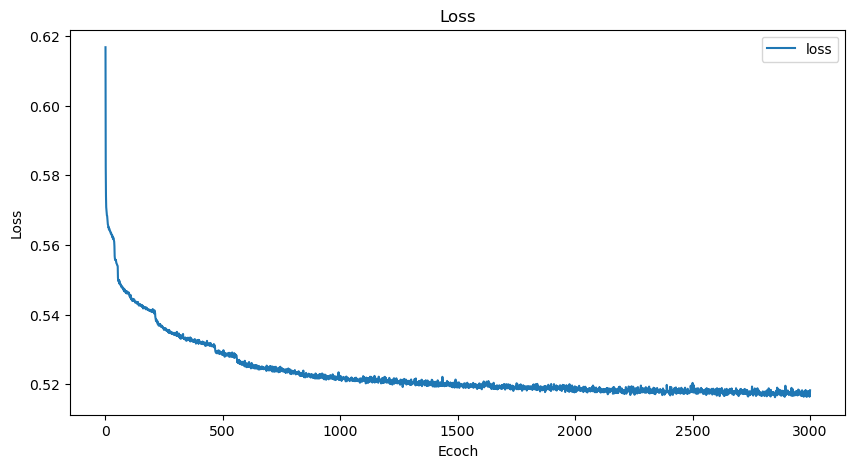

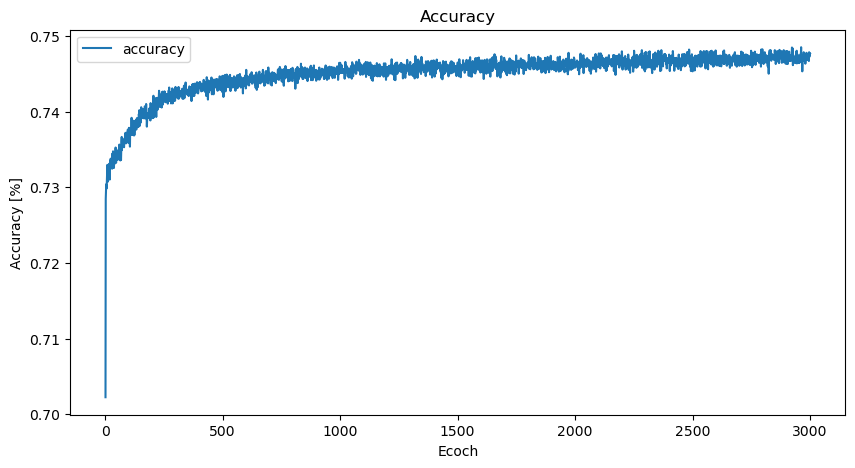

In [37]:
# Evaluate the model using the test data

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss", xlabel='Ecoch', ylabel='Loss', title='Loss')                          # ylim = (0,1)
history_df.plot(y="accuracy", xlabel='Ecoch', ylabel='Accuracy [%]', title='Accuracy')          # ylim = (0,1)

model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [31]:
# Export our model to HDF5 file
#  YOUR CODE GOES HERE
# Export our model to HDF5 file
#  YOUR CODE GOES HERE

now = datetime.now()
acc = str(int(model_accuracy*10000))
filename = now.strftime("%Y-%m-%d-%H%M%S-")+acc+"-weights.hdf5"
nn.save_weights(filename)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filename = now.strftime("%Y-%m-%d-%H%M%S-")+acc+"-model.h5"
nn.save(filename)